In [4]:
"""Globals that will never change"""
C_d = 0.5 # Drag coefficient/constant, unitless
# velocities, (x, y) pairs resp. (m/s)
rho = 1.225 # air density (kg/m^3)
g = 9.80665 # gravitational constant (m/s^2)

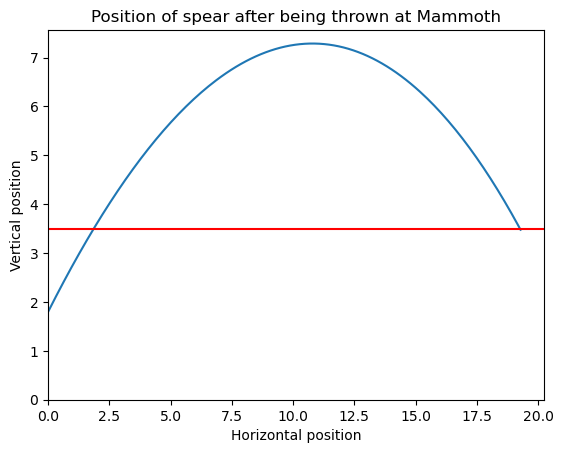

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Constants that may change
A = 0.01 # Surface area of the spear (m^2)
m = 0.5 # mass of the spear (kg)
# Heights in m
HUMAN_HEIGHT = 1.8
MAMMOTH_HEIGHT = 3.5
MAMMOTH_WIDTH = MAMMOTH_HEIGHT * 1.25
DISTANCE_FROM_HUMAN = 20
THETA: float = np.radians(45) # angle of the thrown spear
len_of_spear: float = 0.1
area_of_spear_from_front: float = 0.001
threshold: float = 1

vi: tuple = (15*np.cos(THETA), 15*np.sin(THETA))

def area(angle: float) -> float:
    pass
    #return [AREA_X, AREA_Y]

def trajectory(vi: tuple, dt=0.01) -> None:
    """
    Returns list of x, y positions that traces the path of the thrown spear.
    """
    global HUMAN_HEIGHT, MAMMOTH_HEIGHT

    v = [vi]
    # The spear should pass the y-position of the mammoth once before the while loop
    # ends
    is_second_pass: bool = False
    # lists of x and y positions
    s_x = [0]
    s_y = [HUMAN_HEIGHT]
    #t_final = 0

    while (s_y[-1] >= MAMMOTH_HEIGHT) or (not is_second_pass):
        # update Fdx and Fdy on each iteration
        Fdx = 0.5 * C_d * v[-1][0]**2 * rho * A
        Fdy = 0.5 * C_d * v[-1][1]**2 * rho * A + m * g

        v.append(
            (v[-1][0] - Fdx/m * dt, 
             v[-1][1] - Fdy/m * dt))
        
        s_x.append(s_x[-1] + v[-1][0] * dt)
        s_y.append(s_y[-1] + v[-1][1] * dt)

        if s_y[-1] >= MAMMOTH_HEIGHT:
            is_second_pass = True
        
        #t_final+=dt

    return s_x, s_y

s_x, s_y = trajectory(vi)
plt.plot(s_x, s_y)
plt.xlim(0)
plt.xlabel('Horizontal position')
plt.ylim(0)
plt.ylabel('Vertical position')
plt.title("Position of spear after being thrown at Mammoth")
plt.axhline(MAMMOTH_HEIGHT, color='r')
plt.show()

In [6]:
from manim import *

config.background_color = BLACK
config.verbosity = "WARNING"

In [21]:
%%manim -qm StickFigure

class StickFigure(Scene):
    def construct(self):
        man = SVGMobject("assets/svg/stickman", height=HUMAN_HEIGHT)
        # Unfortunately, it seems that SVG MObjects's color cannot be changed
        # upon instantiation, and must be changed afterwards.
        man.color = WHITE 
        spear = Vector((1, 0.5), color=RED)
        man_and_spear = VGroup(man, spear)

        mammoth = SVGMobject("assets/svg/mammoth", height=MAMMOTH_HEIGHT)
        mammoth.color = WHITE

        # Ensure human and mammoth are standing on the same ground  
        VGroup(man_and_spear, mammoth).arrange(center=False, aligned_edge=DOWN)
        mammoth.to_edge(RIGHT)

        self.play(FadeIn(man_and_spear))
        self.play(man_and_spear.animate.to_edge(LEFT))
        self.play(FadeIn(mammoth))

        s_x, s_y = trajectory(vi)

        axes = Axes(
            x_range=[0, max(s_x)],
            y_range=[0, max(s_y)],
            tips=False
        )
        self.play(Create(axes))
        self.wait()
        # da = DoubleArrow(
        #     (man.get_right()[0], 0, 0), 
        #     (mammoth.get_left()[0], 0, 0))
        # self.wait()
        # self.play(FadeIn(da))
        # dis = Tex("d = 20 m").next_to(da, DOWN)
        # self.play(Write(dis))
        # self.wait()
        # self.play(FadeOut(da), Unwrite(dis))
        # self.wait()

Manim Community v0.18.1

In [8]:
%%manim -qm TrajectoryGraph

class TrajectoryGraph(Scene):
    def construct(self):
        s_x, s_y = trajectory(vi)
        axes = Axes(
            x_range=[0, max(s_x)],
            y_range=[0, max(s_y)],
            tips=False
        ).add_coordinates()
        graph = axes.plot_line_graph(s_x, s_y, add_vertex_dots=False)
        self.play(Create(axes))
        self.wait(0.25)
        self.play(Create(graph))
        self.wait()

Manim Community v0.18.1

In [ ]:
def lethality(v, len_of_spear) -> float:
    """
    Returns 1 if the spear throw will kill the mammoth;
    returns float between 0 and 1 otherwise, giving
    a measure of how close to being lethal the throw is.
    """
    global area_of_spear_from_front, threshold
    # Energy transferred to the skin at the moment of impact
    Ekf = [0.5 * m * (v[-1][0]**2 + v[-1][1]**2)]
    # Translate Ekf to pressure, since that's how the linked paper
    # measure impact
    F = Ekf/len_of_spear # force in Newtons
    pressure = F/area_of_spear_from_front # in pascals (N/m^2)
    if pressure > threshold:
        return 1
    return (pressure/threshold)**2